<a href="https://colab.research.google.com/github/faisal3325/cnn/blob/master/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Individual Project
# Practical Project (Convolutional Neural Networks)          Artificial Intelligence 1                                        Marks=40
           
This project is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this project, you will train a convolutional neural network to classify an image into one of two classes: "cat" or "dog". The code for the neural networks you train will be written for you, and you are not (yet!) expected to understand all provided code. However, by the end of the project, you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.

# Do not panic, Enjoy Deep Leaning :-)

# Submission Instructions (precise and complete write-up)

Submit a PDF file containing all your code, outputs, and write-up from parts 1-4. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions has more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option File -> Print and save as PDF file.

Only PDF file will be evaluated.

NOTE- Use Text cells wherever explaination is required. You can insert images by using the following code in code cell:

from google.colab import files

uploaded = files.upload()

from IPython.display import Image 

Image('NN.png',  width=800, height=500)

# Colab Link (Compulsory for Evaluation) I would not evaluate project without Colab link. Include here.

Colab Link:

Include a link to your colab file here



In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

# Part 0. Helper Functions
We will be making use of the following helper functions. You will be asked to look at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code after making some progress on the project.

In [0]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * 0.8)
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of colour images of size 32x32 pixels belonging to 10 categories. You can find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. We have included code that automatically downloads the dataset the first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:02, 73120185.58it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Part (a) -- 1 pt
Visualize some of the data by running the code below. Include the visualization in your writeup.

(You don't need to submit anything else.)

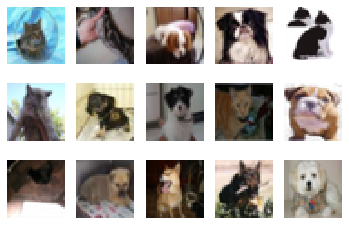

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

# Part (b) -- 3 pt
How many training examples do we have for the combined cat and dog classes? What about validation examples? What about test examples? (insert text cell to answer it)

In [5]:
total_train = len(train_loader)
print('Total training examples: ', total_train)

total_validation = len(val_loader)
print('Total validation examples: ', total_validation)

total_test = len(test_loader)
print('Total testing examples: ', total_test)

Total training examples:  8000
Total validation examples:  2000
Total testing examples:  2000


## **Answer**

So we have total 12,000 samples of both cat and dog classes out of which **8000** is for training; **2000** for validating our model; and **2000** for testing.



# Part (c) -- 3pt
Why do we need a validation set when training our model? What happens if we judge the performance of our models using the training set loss/error instead of the validation set loss/error? (insert text cell to answer it)

## **Answer**

If we test our model with the training set, it would give us 100% accuracy and 0% error as we have used the same data to train our model. The features of the train data are well understood by the neural network.

# Part 2. Training [15 pt]
We define two neural networks, a LargeNet and SmallNet. We'll be training the networks in this section.

You won't understand fully what these networks are doing until the next few classes, and that's okay. For this assignment, please focus on learning how to train networks, and how hyperparameters affect training.

In [0]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
small_net = SmallNet()
large_net = LargeNet()

# Part (a) -- 2pt
The methods small_net.parameters() and large_net.parameters() produces an iterator of all the trainable parameters of the network. These parameters are torch tensors containing many scalar values.

We haven't learned how the parameters in these high-dimensional tensors will be used, but we should be able to count the number of parameters. Measuring the number of parameters in a network is one way of measuring the "size" of a network.

What is the total number of parameters in small_net and in large_net? (Hint: how many numbers are in each tensor?)

(insert text cell to answer it)

In [9]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


In [10]:
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


## **Answer**

Since each tensor is a matrix, the total number of paramaters in a matrix is then defined by the total number of elements in it. So the total number of trainable parameters is calculated as:


**For small net:**
```
(5 * 3 * 3 * 3) + 5 + (1 * 245) + 1 = 386
```

**For large net:**
```
(5 * 3 * 5 * 5) + 5 + (10 * 5 * 5 * 5) + 10 + (32 * 250) + 32 + (1 * 32) + 1 = 9705
```



# The function train_net

The function train_net below takes an untrained neural network (like small_net and large_net) and several other parameters. You should be able to understand how this function works. The figure below shows the high level training loop for a machine learning model:



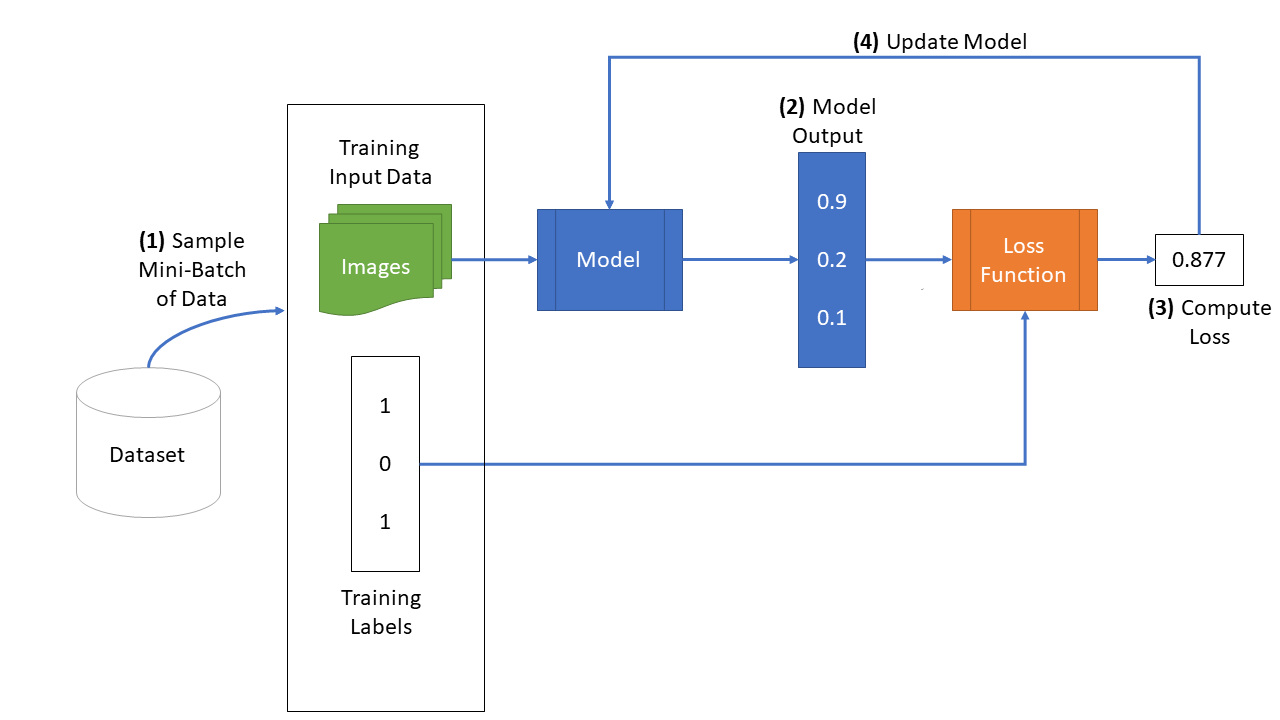

In [28]:
from IPython.display import Image
Image('https://www.cs.toronto.edu/~lczhang/aps360_20191/hw/a2/Diagram.png',  width=800, height=500)

In [0]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

# Part (b) -- 1pt
The parameters to the function train_net are hyperparameters of our neural network. We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters batch_size, learning_rate, and num_epochs? (insert text cell/section header cell to answer)

## **Answer**


The default parameters for **batch_size** is **64**, **learning_rate** is **0.01** and **num_epochs** is **30**

# Part (c) -- 3 pt
What files are written to disk when we call train_net with small_net, and train for 5 epochs? Provide a list of all the files written to disk, and what information the files contain.(insert text cell/section header cell to answer)

In [13]:
train_net(small_net, num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.422125, Train loss: 0.6701607818603516 |Validation err: 0.3735, Validation loss: 0.6544001903384924
Epoch 2: Train err: 0.365375, Train loss: 0.6438680963516236 |Validation err: 0.3875, Validation loss: 0.6590270232409239
Epoch 3: Train err: 0.35025, Train loss: 0.6329235191345215 |Validation err: 0.351, Validation loss: 0.6287356559187174
Epoch 4: Train err: 0.338, Train loss: 0.6191955924034118 |Validation err: 0.375, Validation loss: 0.6342130284756422
Epoch 5: Train err: 0.33325, Train loss: 0.6093687543869019 |Validation err: 0.3475, Validation loss: 0.620696771889925
Finished Training
Total time elapsed: 19.16 seconds


In [14]:
%ls

data/                           model_small_bs64_lr0.01_epoch4_train_err.csv
model_small_bs64_lr0.01_epoch0  model_small_bs64_lr0.01_epoch4_train_loss.csv
model_small_bs64_lr0.01_epoch1  model_small_bs64_lr0.01_epoch4_val_err.csv
model_small_bs64_lr0.01_epoch2  model_small_bs64_lr0.01_epoch4_val_loss.csv
model_small_bs64_lr0.01_epoch3  sample_data/
model_small_bs64_lr0.01_epoch4


In [0]:
import pandas as pd

In [16]:
pd.read_csv('model_small_bs64_lr0.01_epoch4_train_err.csv')

,4.221249999999999725e-01
0,0.365375
1,0.350250
2,0.338000
3,0.333250


In [17]:
pd.read_csv('model_small_bs64_lr0.01_epoch4_train_loss.csv')

,6.701607818603515510e-01
0,0.643868
1,0.632924
2,0.619196
3,0.609369


In [18]:
pd.read_csv('model_small_bs64_lr0.01_epoch4_val_err.csv')

,3.734999999999999987e-01
0,0.3875
1,0.3510
2,0.3750
3,0.3475


In [19]:
pd.read_csv('model_small_bs64_lr0.01_epoch4_val_loss.csv')

,6.544001903384923935e-01
0,0.659027
1,0.628736
2,0.634213
3,0.620697


## **Answer**

The files written are:
```
model_small_bs64_lr0.01_epoch0  
model_small_bs64_lr0.01_epoch1  
model_small_bs64_lr0.01_epoch2  
model_small_bs64_lr0.01_epoch3  
model_small_bs64_lr0.01_epoch4
model_small_bs64_lr0.01_epoch4_train_loss.csv
model_small_bs64_lr0.01_epoch4_train_err.csv
model_small_bs64_lr0.01_epoch4_val_loss.csv
model_small_bs64_lr0.01_epoch4_val_err.csv
```

Here, files with extension `01_epoch_` are the model generated at each epoch, since our `num_epoch` was set to 5, we have 5 files of this type i.e. 5 models ranging from 0 to 4 (`01_epoch0, 01_epoch1, 01_epoch2, 01_epoch3, 01_epoch4`).

Files with `.csv` extension have the statistics of the model at each epoch.

Note: As we can see in the above dataframes; we have 4 rows, with 0th index as the 2nd epoch, 1st index as 3rd epoch and so on... Since we have used a pandas dataframe to visualize the statistics, it has shown us the 1st epoch's statistics in the top row (as the label of the table).

Let's see the individual files:

**`model_small_bs64_lr0.01_epoch4_train_loss.csv`**:
This file has the training loss calculated at each epoch. The loss function used over here was BCE.

We can notice that in each epoch, the loss tends to decrease, which shows that the model is learning at each epoch.

**`model_small_bs64_lr0.01_epoch4_train_err.csv`**:
This file has the error calculated at each epoch while training the model.

Like the loss, error is also decreasing at each epoch, major decrease has been noticed after the first epoch.

**`model_small_bs64_lr0.01_epoch4_val_loss.csv`**:
This file has the validation loss calculated at each epoch. The loss function used over here is also BCE.

Similar to training loss, the loss is decreasing at each epoch.

**`model_small_bs64_lr0.01_epoch4_val_err.csv`**:
This file has the error calculated at each epoch while validating the model.

Similar to training error, it is also decreasing i.e. improving at each epoch.

# Part (d) -- 2pt
Train both small_net and large_net using the function train_net and its default parameters. The function will write many files to disk, including a model checkpoint (saved values of model weights) at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive so that the files generated by train_net gets saved. We will be using these files in part (d). (See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train? Why?

In [20]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [61]:
small_model = train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.439375, Train loss: 0.6837765421867371 |Validation err: 0.3915, Validation loss: 0.6662272289395332
Epoch 2: Train err: 0.380875, Train loss: 0.6527453322410584 |Validation err: 0.3935, Validation loss: 0.6626366525888443
Epoch 3: Train err: 0.342125, Train loss: 0.625328052520752 |Validation err: 0.3335, Validation loss: 0.6186922714114189
Epoch 4: Train err: 0.323875, Train loss: 0.6055600070953369 |Validation err: 0.339, Validation loss: 0.6171749532222748
Epoch 5: Train err: 0.314625, Train loss: 0.5930321733951569 |Validation err: 0.3215, Validation loss: 0.6096237320452929
Epoch 6: Train err: 0.29975, Train loss: 0.581014221906662 |Validation err: 0.3265, Validation loss: 0.6049923654645681
Epoch 7: Train err: 0.2975, Train loss: 0.5773153674602508 |Validation err: 0.3305, Validation loss: 0.600175685249269
Epoch 8: Train err: 0.295125, Train loss: 0.5693165059089661 |Validation err:

In [22]:
large_model = train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.454, Train loss: 0.6919159383773804 |Validation err: 0.4285, Validation loss: 0.6884423270821571
Epoch 2: Train err: 0.43025, Train loss: 0.683244957447052 |Validation err: 0.413, Validation loss: 0.6745339427143335
Epoch 3: Train err: 0.399, Train loss: 0.6649517331123352 |Validation err: 0.384, Validation loss: 0.6507806573063135
Epoch 4: Train err: 0.369125, Train loss: 0.6435128545761108 |Validation err: 0.3775, Validation loss: 0.654183516278863
Epoch 5: Train err: 0.345875, Train loss: 0.629268488407135 |Validation err: 0.3405, Validation loss: 0.6256802882999182
Epoch 6: Train err: 0.3375, Train loss: 0.6145022878646851 |Validation err: 0.3295, Validation loss: 0.609766885638237
Epoch 7: Train err: 0.321875, Train loss: 0.5985584139823914 |Validation err: 0.3375, Validation loss: 0.6081858966499567
Epoch 8: Train err: 0.306125, Train loss: 0.5828263957500458 |Validation err: 0.317, 

## **Answer**

Total time taken by **`small_net`** was: **123.61 secs** and,
the total time taken by **`large_net`** was: **129.19 secs**.

This is due to the network complexity of the networks.

To better understand, let's individually look at each network configuration:

**`large_net`:**

`Step 1:` 

2D Convolution transformation is applied on the data with ReLU (Rectified Linear Unit) as the activation function.
Then max pooling is applied on it.

This step is repeated twice with different configurations of the convolution matrix.

`Step 2:`

Linear transformation is applied then with ReLU as the activiation function it generates 32 features using 250 features.

`Step 3:`

Then finally, linear transformation is applied again with default linear activation function. It generates 1 output feature using 32 features generated from previous step.


**`small_net`:**

`Step 1:` 

2D Convolution transformation is applied on the data with ReLU (Rectified Linear Unit) as the activation function.
Then max pooling is applied on it.

`Step 2:`

Then max pooling is applied on the resultant data from previous step.

`Step 3:`

Linear transformation is applied; it generates 1 feature using 245 features.
<br><br>



Clearly we can see that `large_net` is more complex as compared with `small_net`.
<br><br>

**Thus this explains the significantly greater time taken by `large_net`.**

# Part (e) - 2pt
Use the function plot_training_curve to display the trajectory of the training/validation error and the training/validation loss. You will need to use the function get_model_name to generate the argument to the plot_training_curve function.

Do this for both the small network and the large network. Include both plots in your writeup. 

(include in your colab) you can use the following code to insert any images/plots to your colab 

from google.colab import files

uploaded = files.upload()

from IPython.display import Image 

Image('NN.png',  width=800, height=500)

## **Answer**

In [23]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
print(model_path)

model_small_bs64_lr0.01_epoch29


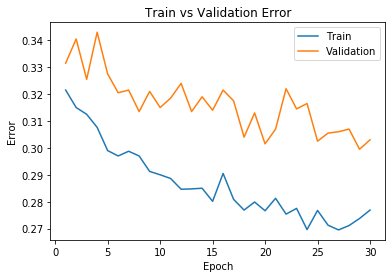

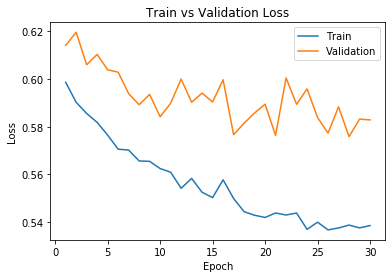

In [24]:
plot_training_curve(model_path)

In [25]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
print(model_path)

model_large_bs64_lr0.01_epoch29


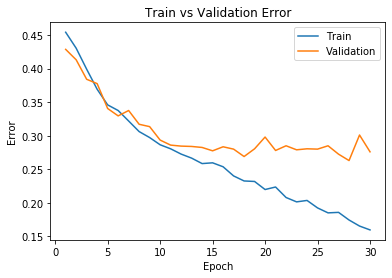

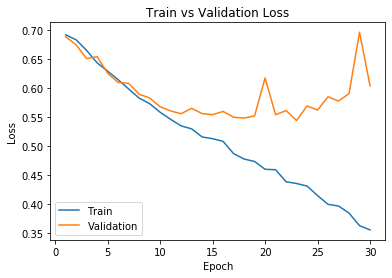

In [26]:
plot_training_curve(model_path)

# Part (f) - 5pt
Describe what you notice about the training curve. How do the curves differ for small_net and large_net? Identify any occurences of underfitting and overfitting.

## **Answer**

As we can see, in small-net, the train and validation plots are on a similar curve i.e. both are decreasing together in the error graph. While in case of large-net, the train and validation plots are on a different path i.e. validation curve has started deflecting from around 12-13 epoch and the error and loss rates have started increasing for it. So we can say, large-net is a classical example of **overfitting**.

# Part 3. Optimization Parameters [12 pt]
For this section, we will work with large_net only.

# Part (a) - 3pt
Train large_net with all default parameters, except set learning_rate=0.001. Does the model take longer/shorter to train? Plot the training curve. Describe the effect of lowering the learning rate.

In [0]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

## **Answer**

In [30]:
re_model = train_net(large_net, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.50225, Train loss: 0.6945205426216126 |Validation err: 0.491, Validation loss: 0.6929904446005821
Epoch 2: Train err: 0.50225, Train loss: 0.6930276579856872 |Validation err: 0.491, Validation loss: 0.6924118660390377
Epoch 3: Train err: 0.48725, Train loss: 0.6922532424926758 |Validation err: 0.4765, Validation loss: 0.6920256800949574
Epoch 4: Train err: 0.448875, Train loss: 0.6916870546340942 |Validation err: 0.4515, Validation loss: 0.6913814526051283
Epoch 5: Train err: 0.442375, Train loss: 0.6910721230506897 |Validation err: 0.4415, Validation loss: 0.6910948026925325
Epoch 6: Train err: 0.440375, Train loss: 0.6903762569427491 |Validation err: 0.4375, Validation loss: 0.6905079521238804
Epoch 7: Train err: 0.437875, Train loss: 0.6895530533790588 |Validation err: 0.434, Validation loss: 0.6896945498883724
Epoch 8: Train err: 0.43925, Train loss: 0.6884702944755554 |Validation err:

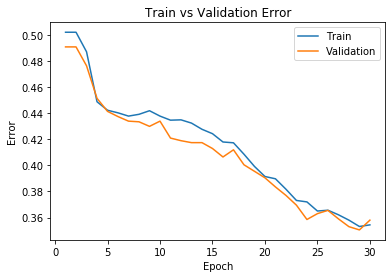

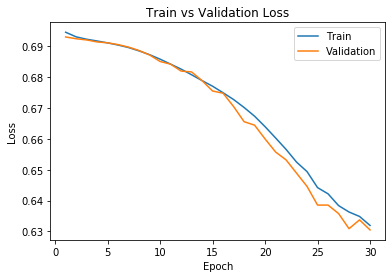

In [31]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

Because of lowering the learning rate to 0.001 (i.e. 10%), we can observe that we have solved the problem of overfitting as well as underfitting leading to **high accurracy**.

With this learning rate, we also noticed that the model has taken **longer time** for training.

# Part (b) - 3pt
Train large_net with all default parameters, except set learning_rate=0.1. Does the model take longer/shorter to train? Plot the training curve. Describe the effect of increasing the learning rate.

## **Answer**

In [41]:
large_net = LargeNet()
re_model = train_net(large_net, learning_rate=0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Validation err: 0

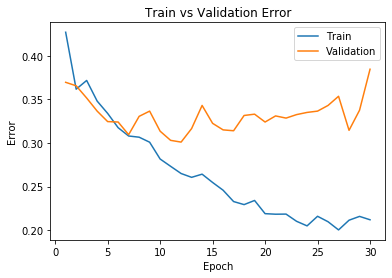

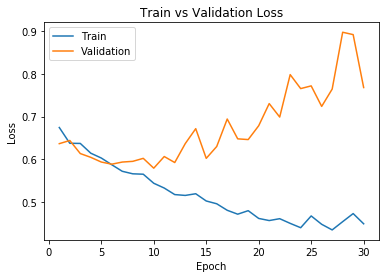

In [42]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

Because of increasing the learning rate to 0.1 (i.e. 10%), we can observe that our model has started **overfitting** as the validation graph is going higher.

The training time is **similar** to the earlier model with 10% less learning rate.


# Part (c) - 3pt
Train large_net with all default parameters, including with learning_rate=0.01. Now, set batch_size=512. Does the model take longer/shorter to train? Plot the training curve. Describe the effect of increasing the batch size.

## **Answer**

In [43]:
large_net = LargeNet()
re_model = train_net(large_net, batch_size=512)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation err: 0.412, V

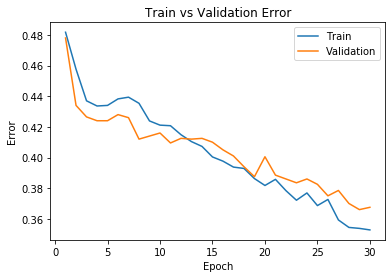

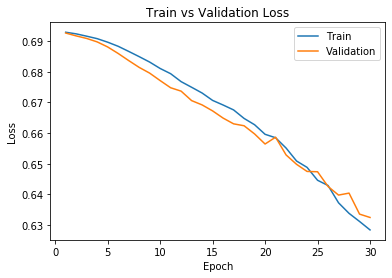

In [44]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

Increasing the batch size has generated a good model. We don't find any case of underfitting as well as overfitting. Since we got a similar model with low learning rate, we can say that batch size effects accuracy majorly.

But the **training time has** **decreased** with the same learning rate as our earlier model.

# Part (d) - 3pt
Train large_net with all default parameters, including with learning_rate=0.01. Now, set batch_size=16. Does the model take longer/shorter to train? Plot the training curve. Describe the effect of decreasing the batch size.

## **Answer**

In [45]:
large_net = LargeNet()
re_model = train_net(large_net, batch_size=16)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

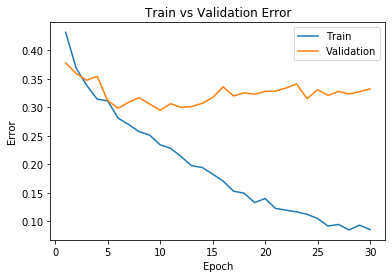

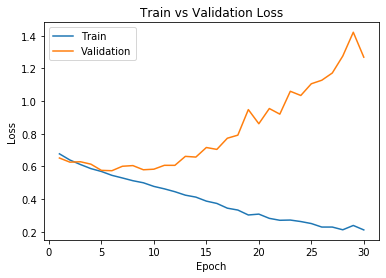

In [46]:
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

Decreasing the batch size has **overfitted** our model from the 1st iteration itself.

Also the **training time has increased** significantly with the same learning rate as out earlier model.

# Part 4. Hyperparameter Search [6 pt]
# Part (a) - 2pt
Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate) that you think would help you improve the validation accuracy. Justify your choice.

## **Answer**

We will try **large_net** with a batch size of **64** and learning rate **0.0001**. We hope with a lower learning rate and a higher batch size, we might get a better model.


# Part (b) - 1pt
Train the model with the hyperparameters you chose in part(a), and include the training curve

## **Answer**


In [56]:
large_net = LargeNet()
re_model = train_net(large_net, batch_size=64, learning_rate=0.0001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930470848083496 |Validation err: 0.4955, Validation loss: 0.6930972076952457
Epoch 2: Train err: 0.483375, Train loss: 0.6929886975288391 |Validation err: 0.494, Validation loss: 0.6930004619061947
Epoch 3: Train err: 0.48075, Train loss: 0.6929271593093872 |Validation err: 0.492, Validation loss: 0.6929453704506159
Epoch 4: Train err: 0.479125, Train loss: 0.6928676853179931 |Validation err: 0.49, Validation loss: 0.6929194442927837
Epoch 5: Train err: 0.4745, Train loss: 0.6928056483268737 |Validation err: 0.4875, Validation loss: 0.6928162518888712
Epoch 6: Train err: 0.471375, Train loss: 0.6927451086044312 |Validation err: 0.4825, Validation loss: 0.6926344819366932
Epoch 7: Train err: 0.467, Train loss: 0.6926863884925842 |Validation err: 0.4755, Validation loss: 0.6926917266100645
Epoch 8: Train err: 0.465625, Train loss: 0.6926283669471741 |Validation err: 0.4

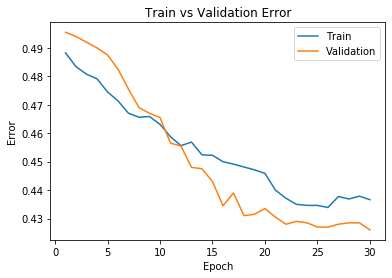

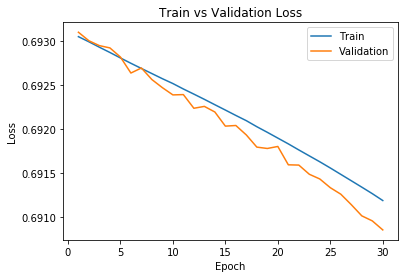

In [57]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.0001, epoch=29)
plot_training_curve(model_path)

# Part (c) - 2pt
Based on your result from Part(a), suggest another set of hyperparameter values to try. Justify your choice.

## **Answer**

We will try **small_net** with a batch size of **512** and learning rate **0.001**. We hope with a lower learning rate and a higher batch size, we might get a better model.


# Part (d) - 1pt
Train the model with the hyperparameters you chose in part(c), and include the training curve.

## **Answer**

In [58]:
small_net = SmallNet()
re_model = train_net(small_net, batch_size=512, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.5005, Train loss: 0.6991336420178413 |Validation err: 0.4925, Validation loss: 0.6945076286792755
Epoch 2: Train err: 0.48, Train loss: 0.6934637613594532 |Validation err: 0.4755, Validation loss: 0.6918978244066238
Epoch 3: Train err: 0.48175, Train loss: 0.6918338611721992 |Validation err: 0.465, Validation loss: 0.6914202272891998
Epoch 4: Train err: 0.472375, Train loss: 0.6913324259221554 |Validation err: 0.4645, Validation loss: 0.6911139637231827
Epoch 5: Train err: 0.469125, Train loss: 0.6907239928841591 |Validation err: 0.4565, Validation loss: 0.6905251294374466
Epoch 6: Train err: 0.466875, Train loss: 0.6903562173247337 |Validation err: 0.459, Validation loss: 0.6900540441274643
Epoch 7: Train err: 0.4635, Train loss: 0.6899680905044079 |Validation err: 0.4625, Validation loss: 0.6895745396614075
Epoch 8: Train err: 0.461, Train loss: 0.6896125487983227 |Validation err: 0.4605

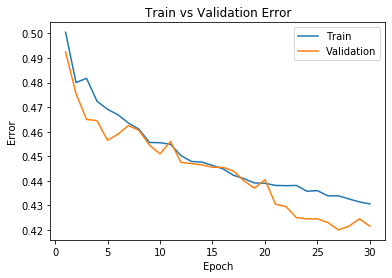

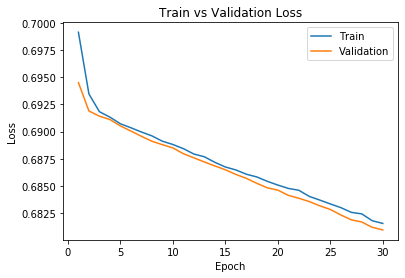

In [59]:
model_path = get_model_name("small", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)